# Evaluamos con algunas métricas

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import numpy as np

# Drums - KWS - Audioset

In [18]:
import itertools

metric = 'auc_relaxed'

dataset = 'drums'
base_path = f'/home/ec2-user/evaluations/{dataset}'

if metric == 'auc':
    value = 'roc_auc'
    intersection = '0.05'
if metric == 'leo_metric':
    value = 'leo_metric'
    intersection = '0'
if metric == 'auc_relaxed':
    value = 'roc_auc'
    intersection = '0.09'

files_auc = [
    f'{base_path}/{metric}_kernel_shap_sumcons_p{{}}_w{{}}_f{{}}_m{{}}_{intersection}.tsv',
    f'{base_path}/{metric}_linear_regression_noreg_noweights_p{{}}_w{{}}_f{{}}_m{{}}_{intersection}.tsv',
    f'{base_path}/{metric}_tree_importance_p{{}}_w{{}}_f{{}}_m{{}}_{intersection}.tsv',
]

methods = ['kernel_shap_sumcons', 'linear_regression_noreg_noweights', 'tree_importance']

ps = [0.2, 0.3, 0.4]
ws = [1, 3, 5]
fs = ['euclidean']
ms = ['zeros', 'stat', 'noise']

dfs = []
for method, file_template in zip(methods, files_auc):
    for p, w, f, m in itertools.product(ps, ws, fs, ms):
        file_path = file_template.format(p, w, f, m)
        try:
            df = pd.read_csv(file_path, sep='\t')
            df['method'] = method
            df['mask_percentage'] = p
            df['window_size'] = w
            df['distance_function'] = f
            df['masking_strategy'] = m
            dfs.append(df)
        except FileNotFoundError:
            print(f"File not found: {file_path}")

final_df = pd.concat(dfs, ignore_index=True)

In [19]:
files_auc_complete = [
    f'{base_path}/{metric}_kernel_shap_sumcons_{{}}_{intersection}.tsv',
    f'{base_path}/{metric}_linear_regression_noreg_noweights_{{}}_{intersection}.tsv',
    f'{base_path}/{metric}_tree_importance_{{}}_{intersection}.tsv',
]
names = ["zeros", "noise", "stat", "all"]

df_combinations = []
for method, file_template in zip(methods, files_auc_complete):
    for name in names:
        file_path = file_template.format(name)
        try:
            df_combination = pd.read_csv(file_path, sep='\t')
            df_combination['method'] = method
            df_combination['name'] = name
            df_combinations.append(df_combination)
        except FileNotFoundError:
            print(f"File not found: {file_path}")
            
final_df_combination_auc = pd.concat(df_combinations, ignore_index=True)


In [85]:
final_df = final_df[final_df['event_label'] == 74]
final_df_combination = final_df_combination[final_df_combination['event_label'] == 74]

In [86]:
mean_auc_df = final_df.groupby(['method', 'mask_percentage', 'masking_strategy', 'window_size'])[value].mean().reset_index()

In [87]:
mean_auc_df_combination = final_df_combination.groupby(['method', 'name'])[value].mean().reset_index()

/tmp/ipykernel_3460947/444739956.py:50: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pivot_table.applymap(lambda x: f"{x:.2f}".lstrip('0')),
/tmp/ipykernel_3460947/444739956.py:50: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pivot_table.applymap(lambda x: f"{x:.2f}".lstrip('0')),


/tmp/ipykernel_3460947/444739956.py:50: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pivot_table.applymap(lambda x: f"{x:.2f}".lstrip('0')),


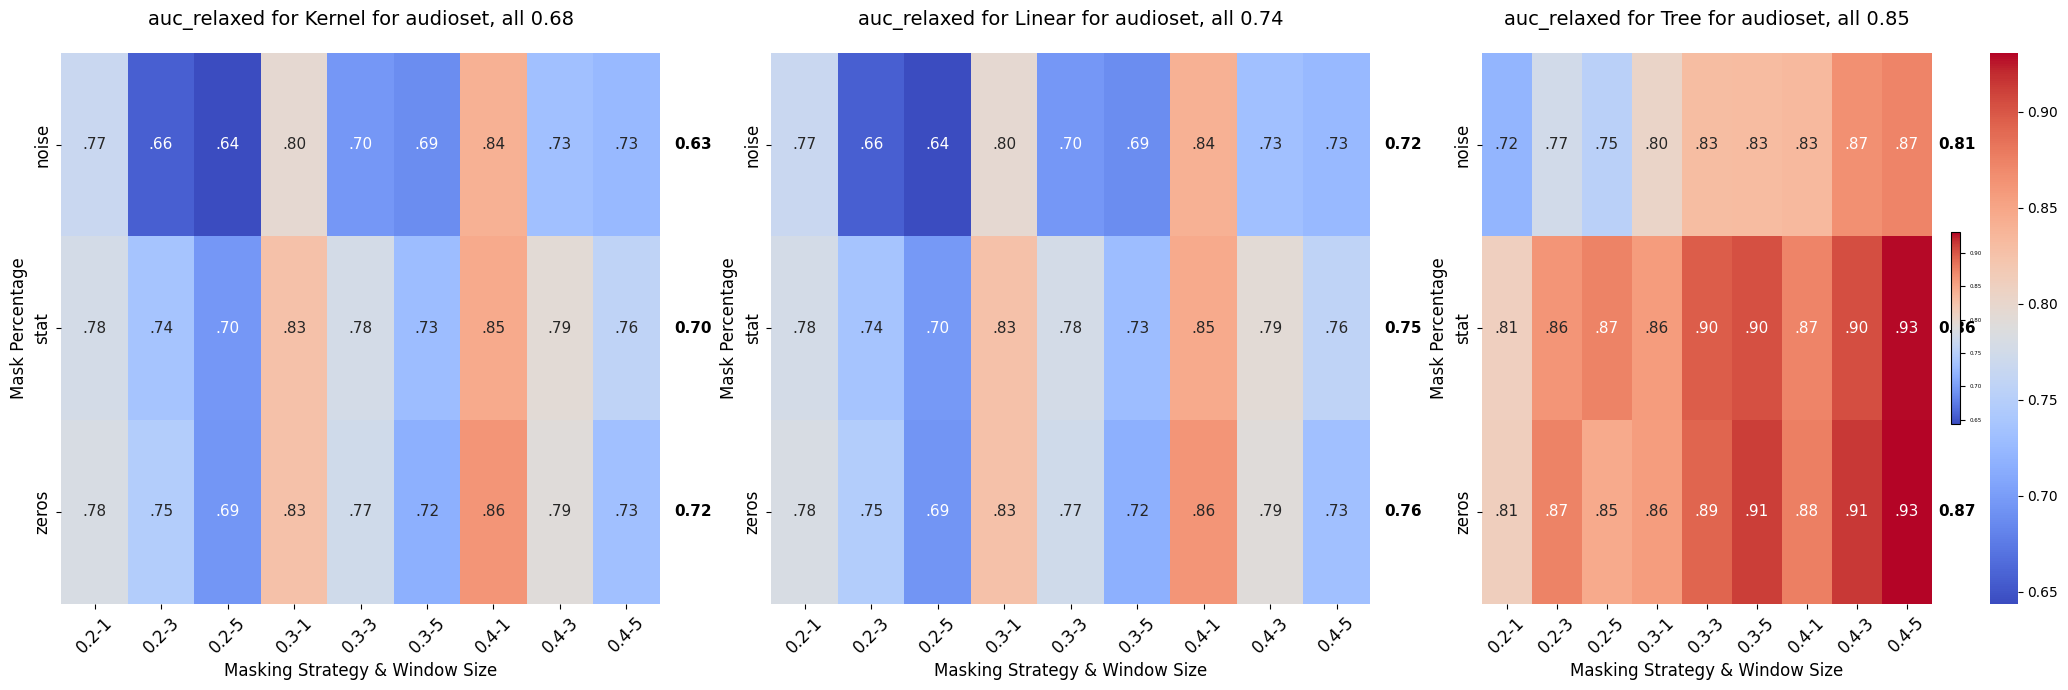

In [88]:
TITLE_SIZE = 14
LABEL_SIZE = 12
ANNOT_SIZE = 11
TICK_SIZE = 12

max_auc = mean_auc_df[value].max()
min_auc = mean_auc_df[value].min()

# Create a figure with subplots for each method
methods = mean_auc_df['method'].unique()
n_methods = len(methods)

# Calculate number of columns and rows
n_cols = 3  # Ceiling division to handle odd numbers
n_rows =1

# Create figure with adjusted size
fig, axes = plt.subplots(n_rows, n_cols, figsize=(7*n_cols, 7*n_rows))
axes = axes.flatten()  # Flatten axes array for easier iteration

# Hide extra subplots if number of methods is odd
if n_methods < len(axes):
    for idx in range(n_methods, len(axes)):
        axes[idx].set_visible(False)

for idx, method in enumerate(methods):
    ax = axes[idx]

    # Create pivot table for current method
    pivot_table = mean_auc_df[mean_auc_df['method'] == method].pivot(
        index='masking_strategy', 
        columns=['mask_percentage', 'window_size'], 
        values=value
    )

    # 🔹 Filter df_annotations for the current method
    annotations = mean_auc_df_combination[mean_auc_df_combination['method'] == method].set_index('name')[value]

    # 🔹 Extract values for row annotations
    row_labels = pivot_table.index
    row_annotations = [annotations.get(label, '') for label in row_labels]  # Get roc_auc or empty string

    # 🔹 Extract values for column annotations
    # col_labels = pivot_table.columns
    # col_annotations = [annotations.get(f"{col[0]}-{col[1]}", '') for col in col_labels]  # Convert tuple to string key

    # Create heatmap
    sns.heatmap(
        pivot_table,
        annot=pivot_table.applymap(lambda x: f"{x:.2f}".lstrip('0')),
        cmap="coolwarm",
        fmt="",
        ax=ax,
        vmin=min_auc,
        vmax=max_auc,
        cbar=(idx == n_methods-1),
        annot_kws={'size': ANNOT_SIZE}
    )
    all = round(mean_auc_df_combination[(mean_auc_df_combination['method'] == method) & (mean_auc_df_combination['name'] == 'all')][value].values[0], 2)
    # all = 'not yet'
    method = method.split('_')[0].capitalize()
    ax.set_title(f'{metric} for {method} for {dataset}, all {all}', fontsize=TITLE_SIZE, pad=20)
    ax.set_xlabel('Masking Strategy & Window Size', fontsize=LABEL_SIZE)
    ax.set_ylabel('Mask Percentage', fontsize=LABEL_SIZE)

    # Set tick label sizes
    ax.tick_params(axis='both', which='major', labelsize=TICK_SIZE)
    ax.tick_params(axis='x', rotation=45)
    if idx == n_methods-1:
        cbar = plt.colorbar(ax.collections[0], ax=ax, fraction=0.02, pad=0.04)
        cbar.ax.tick_params(labelsize=4)
    # 🔹 **Annotate rows (masking strategies)**
    for i, valu in enumerate(row_annotations):
        ax.text(pivot_table.shape[1] + 0.5, i + 0.5, f"{valu:.2f}" if valu else "", 
                ha='center', va='center', fontsize=ANNOT_SIZE, color='black', fontweight='bold')

    # 🔹 **Annotate columns (mask percentages & window sizes)**
    # for j, valu in enumerate(col_annotations):
    #     ax.text(j + 0.5, -0.5, f"{valu:.2f}" if valu else "", 
    #             ha='center', va='center', fontsize=ANNOT_SIZE, color='black', fontweight='bold')

plt.tight_layout()
plt.show()


# Audioset


In [93]:
# Filtramos 
names_to_filter = final_df.groupby(['filename', 'event_label'])[value].mean().reset_index()

In [86]:
roc_auc = names_to_filter[names_to_filter['roc_auc'] > 0.60]
names_roc_auc = roc_auc[roc_auc['event_label'].isin([0, 27, 70, 74, 137, 288, 306])]
names_roc_auc = names_roc_auc[['filename', 'event_label']]

In [79]:
names_roc_auc.to_csv('/home/ec2-user/explain_where/preprocess/files_to_process.csv', index=False)

In [102]:
filtered_df = final_df.merge(names_roc_auc, on=["filename", "event_label"], how="inner")
filtered_df_combination = final_df_combination.merge(names_roc_auc, on=["filename", "event_label"], how="inner")

In [103]:
mean_auc_df = filtered_df.groupby(['method', 'mask_percentage', 'masking_strategy', 'window_size'])[value].mean().reset_index()
mean_auc_df_combination = filtered_df_combination.groupby(['method', 'name'])[value].mean().reset_index()

# Faithfulness


In [40]:
import numpy as np

def compute_log_odds(scores):
    def softmax(x):
        exp_x = np.exp(x - np.max(x))  
        return exp_x / exp_x.sum()

    scores_array = np.array(scores)

    if scores_array.ndim == 1:
        probs = softmax(scores_array)
    else: 
        probs = np.apply_along_axis(softmax, axis=1, arr=scores_array)

    log_odds = np.log(probs / (1 - probs))
    return log_odds.tolist()


In [70]:
import ast

metric = 'score_curve'
methods = ['kernel_shap_sumcons', 'linear_regression_noreg_noweights', 'tree_importance']

dataset = 'drums'
base_path = f'/home/ec2-user/evaluations/{dataset}'

files_auc_complete = [
    f'{base_path}/{metric}_kernel_shap_sumcons_{{}}.tsv',
    f'{base_path}/{metric}_linear_regression_noreg_noweights_{{}}.tsv',
    f'{base_path}/{metric}_tree_importance_{{}}.tsv',
]

names = ["zeros", "noise", "stat", "all"]
# names=['zeros', 'noise']
metric = 'score_curve'

df_combinations = []
for method, file_template in zip(methods, files_auc_complete):
    for name in names:
        file_path = file_template.format(name)
        try:
            df_combination = pd.read_csv(file_path, sep='\t')
            df_combination['method'] = method
            df_combination['name'] = name
            if metric == 'score_curve':
                df_combination['actual_score'] = df_combination['actual_score'].apply(ast.literal_eval)
                df_combination['score_curve_sacando_topk'] = df_combination['score_curve_sacando_topk'].apply(ast.literal_eval)
                df_combination['event_label'] = df_combination['event_label'].apply(int)

                df_combination['log_odds'] = df_combination['actual_score'].apply(compute_log_odds)
                df_combination['log_odds_curve'] = df_combination['score_curve_sacando_topk'].apply(compute_log_odds)

                percentages = [0.01, 0.05, 0.1, 0.25, 0.3, 0.4, 0.5]
                for i in percentages:
                    df_combination[f'top_{i}'] = df_combination.apply(
                        lambda row: row['log_odds'][row['event_label']] - row['log_odds_curve'][int(len(row['score_curve_sacando_topk']) * i)][row['event_label']],
                        axis=1
                    )

        except FileNotFoundError:
            print(f"File not found: {file_path}")

        df_combinations.append(df_combination)
            
final_df_combination = pd.concat(df_combinations, ignore_index=True)

In [76]:
test = final_df_combination_auc[final_df_combination_auc['name'].isin(['zeros'])  & final_df_combination_auc['method'].isin(['tree_importance'])]
test1 = final_df_combination[final_df_combination['name'].isin(['zeros']) & final_df_combination['method'].isin(['tree_importance'])]

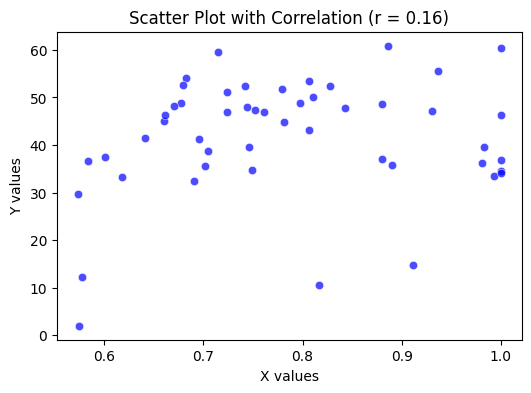

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

corr, _ = pearsonr(test['roc_auc'], test1['top_0.25'])

# Create scatter plot
plt.figure(figsize=(6, 4))
sns.scatterplot(x=test['roc_auc'], y=final_df_combination['top_0.25'], color="blue", alpha=0.7)
plt.title(f"Scatter Plot with Correlation (r = {corr:.2f})")
plt.xlabel("X values")
plt.ylabel("Y values")

# Show plot
plt.show()

,filename,event_label,actual_score,score_curve_sacando_topk,score_curve_consolo_topk,method,name,log_odds,log_odds_curve,top_0.01,top_0.05,top_0.1,top_0.25,top_0.3,top_0.4,top_0.5
0,5057.wav,5,"[-6.564869403839111, -7.203338623046875, -15.1...","[[-6.6118483543396, -7.274680137634277, -15.27...","[[1.6865832805633545, 19.142114639282227, 1.10...",kernel_shap_sumcons,zeros,"[-25.76882990201913, -26.407299121229933, -34....","[[-28.76443093475244, -29.427262718047274, -37...",19.175159,19.387518,49.710947,56.988167,57.287445,49.938638,55.979774
1,1049.wav,1,"[1.2770440578460693, 19.245357513427734, 2.340...","[[1.2619540691375732, 19.654306411743164, 2.41...","[[17.458303451538086, 2.931917667388916, -5.75...",kernel_shap_sumcons,zeros,"[-17.96831350111364, 16.608264932243145, -16.9...","[[-23.404288288685194, -5.0052556814932805, -2...",21.613521,36.514224,36.510545,37.340072,37.375564,37.438166,37.326525
2,5059.wav,5,"[-7.7152018547058105, -8.757121086120605, -17....","[[-7.617830753326416, -9.266018867492676, -17....","[[-13.169782638549805, -10.08397102355957, 8.7...",kernel_shap_sumcons,zeros,"[-30.246964934824337, -31.288884166239182, -40...","[[-30.086610533949735, -31.73479864811606, -40...",21.640691,36.169247,49.000806,62.707137,63.363172,56.886693,58.037303
3,3033.wav,3,"[-17.933399200439453, -18.15264129638672, -3.9...","[[-17.345422744750977, -17.127649307250977, -1...","[[0.8535096645355225, 15.701089859008789, 1.85...",kernel_shap_sumcons,zeros,"[-30.775852895620663, -30.99509499156794, -16....","[[-39.8475702214871, -39.6297967839871, -24.07...",23.831671,23.827423,36.425728,43.534530,52.965741,51.465177,42.853617
4,5079.wav,5,"[-6.567137241363525, -7.17333459854126, -14.61...","[[-6.544856071472168, -7.15300178527832, -14.5...","[[1.3885167837142944, 16.70935821533203, 1.319...",kernel_shap_sumcons,zeros,"[-25.83342223688938, -26.439619594069857, -33....","[[-27.688111013145488, -28.29625672695207, -35...",18.580762,38.981882,39.727287,19.027016,39.530444,55.207219,59.039256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,3082.wav,3,"[-18.135332107543945, -18.91012954711914, -3.3...","[[-10.873420715332031, -5.707723617553711, 12....","[[19.126977920532227, 2.4614341259002686, -6.5...",tree_importance,noise,"[-31.646837370542244, -32.421634810117446, -16...","[[-32.64033311103578, -27.474636013256294, -8....",38.140325,56.613459,44.313163,36.877135,59.234687,57.401374,42.206995
296,4073.wav,4,"[-7.230021953582764, -9.0643949508667, -15.511...","[[-11.73019027709961, -14.272542953491211, -16...","[[19.60845375061035, 2.59700608253479, -6.8688...",tree_importance,noise,"[-19.473095727081915, -21.307468727299238, -27...","[[-34.86259810017791, -37.404950776569514, -39...",3.290791,19.640866,19.435271,19.929643,34.439370,43.384584,38.158531
297,5021.wav,5,"[-6.844186305999756, -7.58380651473999, -15.88...","[[-6.810232162475586, -7.562386989593506, -15....","[[17.798452377319336, 2.8016128540039062, -5.8...",tree_importance,noise,"[-26.58412891691722, -27.323749125658942, -35....","[[-28.859912220220092, -29.61206704733817, -37...",18.973176,19.783974,40.177874,56.380901,58.256938,49.852246,50.890160
298,3048.wav,3,"[-17.150842666625977, -17.299211502075195, -3....","[[-15.018132209777832, -17.15393829345703, -12...","[[4.984525680541992, 13.920524597167969, -0.54...",tree_importance,noise,"[-29.50347957092716, -29.6518484063764, -15.90...","[[-36.27388341986393, -38.40968950354313, -34....",35.502680,36.217728,22.543450,52.938814,51.783455,53.737171,53.320469


In [ ]:
# import ast
# import pandas as pd


# # Apply literal_eval to convert string representations of lists into actual lists
# final_df_combination['score_curve_sacando_topk'] = final_df_combination['score_curve_sacando_topk'].apply(ast.literal_eval)
# final_df_combination['event_label'] = final_df_combination['event_label'].apply(int)
# # Assuming final_df_combination is already loaded
# for i in [1, 3, 5, 10]:
#     final_df_combination[f'top_{i}'] = final_df_combination.apply(
#         lambda row: row['actual_score'] - row['score_curve_sacando_topk'][i-1][row['event_label']], axis=1
#     )

# # Print to verify
# print(final_df_combination.head())


In [46]:
top_k_values = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
mean_auc_df_combination = final_df_combination.groupby(['method', 'name'])[
    [f'top_{i}' for i in top_k_values]
].mean().reset_index()
mean_auc_df_combination

,method,name,top_0.01,top_0.05,top_0.1,top_0.2,top_0.3,top_0.4,top_0.5
0,kernel_shap_sumcons,all,5.725856,12.792137,16.580405,21.738282,23.770278,24.584969,24.416737
1,kernel_shap_sumcons,noise,4.814108,11.691838,15.265576,17.529820,17.048706,13.524813,8.466364
2,kernel_shap_sumcons,stat,7.971662,14.699577,19.785671,25.687070,29.575641,31.629639,32.706527
3,kernel_shap_sumcons,zeros,7.968621,14.841953,20.056012,26.121658,30.173916,32.491917,33.993569
4,linear_regression_noreg_noweights,all,6.046487,13.182638,17.017217,22.308883,24.913909,25.927298,25.479728
5,linear_regression_noreg_noweights,noise,5.104418,11.936985,15.134013,17.778515,17.916494,15.730066,12.184072
6,linear_regression_noreg_noweights,stat,7.882723,14.936860,19.884967,25.917244,29.906178,32.464521,33.773257
7,linear_regression_noreg_noweights,zeros,7.893128,14.954298,20.026325,26.284015,30.579531,33.451680,35.159156
8,tree_importance,all,6.698259,13.188518,16.113573,19.365243,20.273041,20.701104,19.553388
9,tree_importance,noise,4.621371,7.595605,5.866789,2.000747,0.126366,-0.820640,-3.579381


In [28]:
top_k_values = [1, 3, 5, 10]

# Compute the mean for each top_k value grouped by 'method' and 'name'
mean_auc_df_combination = final_df_combination.groupby(['method', 'name'])[
    [f'top_{i}' for i in top_k_values]
].mean().reset_index()

mean_auc_df_combination.to_csv(f'/home/ec2-user/evaluations/{dataset}/faithfulness.csv', index=False)

# Cough

In [ ]:
import itertools

base_path = '/home/ec2-user/evaluations/cough'

files_auc_complete = [
    f'{base_path}/{metric}_kernel_shap_sumcons_{{}}.tsv',
    f'{base_path}/{metric}_linear_regression_noreg_noweights_{{}}.tsv',
    f'{base_path}/{metric}_tree_importance_{{}}.tsv',
]

methods = ['kernel_shap_sumcons', 'linear_nocons', 'tree_importance' 'kernel_shap', 'linear_regression']
ps = [0.2, 0.3, 0.4]
ws = [1, 3, 5]
fs = ['euclidean']
ms = ['zeros', 'stat', 'noise']

dfs = []
for method, file_template in zip(methods, files_auc_new_alg):
    for p, w, f, m in itertools.product(ps, ws, fs, ms):
        file_path = file_template.format(p, w, f, m)
        try:
            df = pd.read_csv(file_path, sep='\t')
            df['method'] = method
            df['mask_percentage'] = p
            df['window_size'] = w
            df['distance_function'] = f
            df['masking_strategy'] = m
            dfs.append(df)
        except FileNotFoundError:
            print(f"File not found: {file_path}")

final_df = pd.concat(dfs, ignore_index=True)

mean_auc_df = final_df.groupby(['method', 'mask_percentage', 'masking_strategy', 'window_size'])['roc_auc'].mean().reset_index()

# Drums test

In [12]:
import itertools
base_path = f'/home/ec2-user/evaluations/drums_test'
metric = 'order'
names = ["zeros", "noise", "stat", "all"]
methods = ['kernel_shap_sumcons', 'linear_regression_noreg_noweights', 'tree_importance']

files_auc_complete = [
    f'{base_path}/{metric}_kernel_shap_sumcons_{{}}_{{}}.tsv',
    f'{base_path}/{metric}_linear_regression_noreg_noweights_{{}}_{{}}.tsv',
    f'{base_path}/{metric}_tree_importance_{{}}_{{}}.tsv',
]
names = ["zeros", "noise", "stat", "all"]

df_combinations = []
for method, file_template in zip(methods, files_auc_complete):
    for i in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
        for name in names:
            file_path = file_template.format(name, i)
            try:
                df_combination = pd.read_csv(file_path, sep='\t')
                df_combination['method'] = method
                df_combination['name'] = name
                df_combination['final'] = i
                df_combinations.append(df_combination)
            except FileNotFoundError:
                print(f"File not found: {file_path}")
                
final_df_combination = pd.concat(df_combinations, ignore_index=True)


In [13]:
final_df_combination

,filename,event_label,actual_score,real_order,model_order,roc_auc,true_markers,method,name,final
0,5057.wav,5.0,19.203960,[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[ 4.21268328 6.04121641 0.52186968 1.666075...,0.957983,"[[0.0, 0.255], [0.255, 0.409], [0.578, 1.448],...",kernel_shap_sumcons,zeros,0.1
1,1049.wav,1.0,19.245358,[0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. ...,[-4.73105364e-01 -4.71345211e-02 -2.37530525e+...,1.000000,"[[0.532, 0.808]]",kernel_shap_sumcons,zeros,0.1
2,5059.wav,5.0,22.531763,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[-4.67516303e+00 2.37626919e-01 4.80940234e-...,1.000000,"[[2.647, 2.763], [2.763, 3.087], [3.087, 3.576...",kernel_shap_sumcons,zeros,0.1
3,3033.wav,3.0,12.842453,[1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. ...,[ 1.98040964e+00 -3.05090014e-01 6.87092920e-...,0.995652,"[[0.0, 0.568], [1.474, 2.275], [6.12, 6.895]]",kernel_shap_sumcons,zeros,0.1
4,5079.wav,5.0,19.266285,[1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. ...,[ 2.94964348 3.13694465 -0.19710959 -1.237967...,0.943750,"[[0.0, 0.511], [0.511, 0.799], [1.619, 2.206],...",kernel_shap_sumcons,zeros,0.1
...,...,...,...,...,...,...,...,...,...,...
3595,3082.wav,3.0,13.511505,[1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0.02340648 0.01752352 0.00857809 0.00645889 0...,0.770588,"[[0.0, 0.876], [3.176, 3.291], [3.291, 3.473]]",tree_importance,all,0.6
3596,4073.wav,4.0,7.661210,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. ...,[0.01408409 0.01329725 0.01107818 0.01075192 0...,0.905882,"[[1.457, 1.875], [3.369, 3.591], [3.737, 3.847...",tree_importance,all,0.6
3597,5021.wav,5.0,19.739943,[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. ...,[0.00818665 0.00468281 0.00484332 0.00598411 0...,0.942029,"[[0.411, 1.123], [1.706, 2.07], [2.07, 2.637],...",tree_importance,all,0.6
3598,3048.wav,3.0,12.352636,[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. ...,[0.03255685 0.00941481 0.0080424 0.01004132 0...,0.830263,"[[0.978, 1.423], [4.141, 4.999], [4.999, 5.659]]",tree_importance,all,0.6


In [15]:
final_df_combination['group'] = final_df_combination['method'] + '_' + \
                    final_df_combination['name'].astype(str)

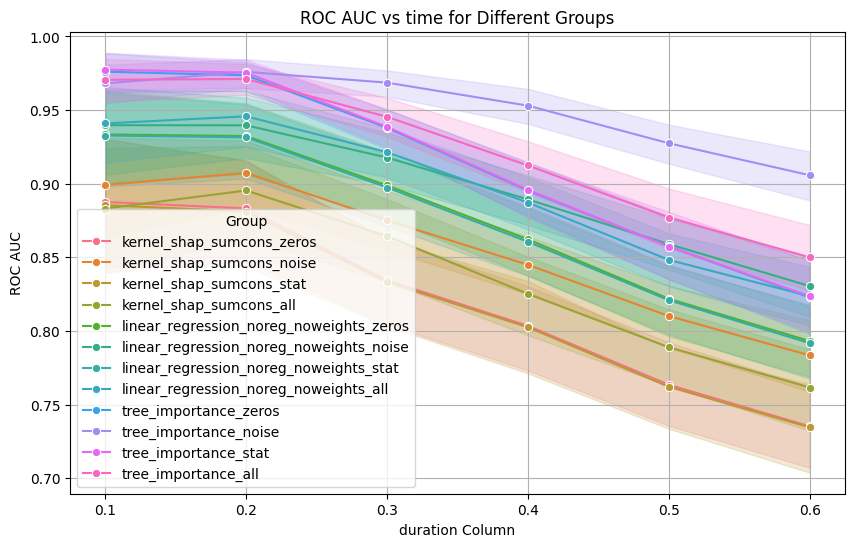

In [25]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=final_df_combination, x="final", y="roc_auc", hue="group", marker="o")

# Labels and Title
plt.xlabel("duration Column")
plt.ylabel("ROC AUC")
plt.title("ROC AUC vs time for Different Groups")

# Show the plot
plt.legend(title="Group")
# plt.legend().remove()

plt.grid(True)
plt.show()